In [56]:
import pandas as pd
import matplotlib
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA 

In [57]:
og_data = pd.read_csv(r'data/Historical Product Demand.csv')

In [58]:
og_data.info()
og_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Product_Code      1048575 non-null  object
 1   Warehouse         1048575 non-null  object
 2   Product_Category  1048575 non-null  object
 3   Date              1037336 non-null  object
 4   Order_Demand      1048575 non-null  object
dtypes: object(5)
memory usage: 40.0+ MB


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [59]:
og_data.dropna(inplace= True)


In [60]:
# The characters () need \ because they are special characters for rege
og_data['Order_Demand']= og_data['Order_Demand'].str.replace('\)','', regex=True)
og_data['Order_Demand']= og_data['Order_Demand'].str.replace('\(','', regex=True)


In [61]:
og_data['Order_Demand'] =  og_data['Order_Demand'].astype(int)
og_data['Date'] = og_data['Date'].astype('datetime64[ns]')

In [62]:
og_data.nunique()
og_data = og_data.set_index('Date')

<Axes: xlabel='Date'>

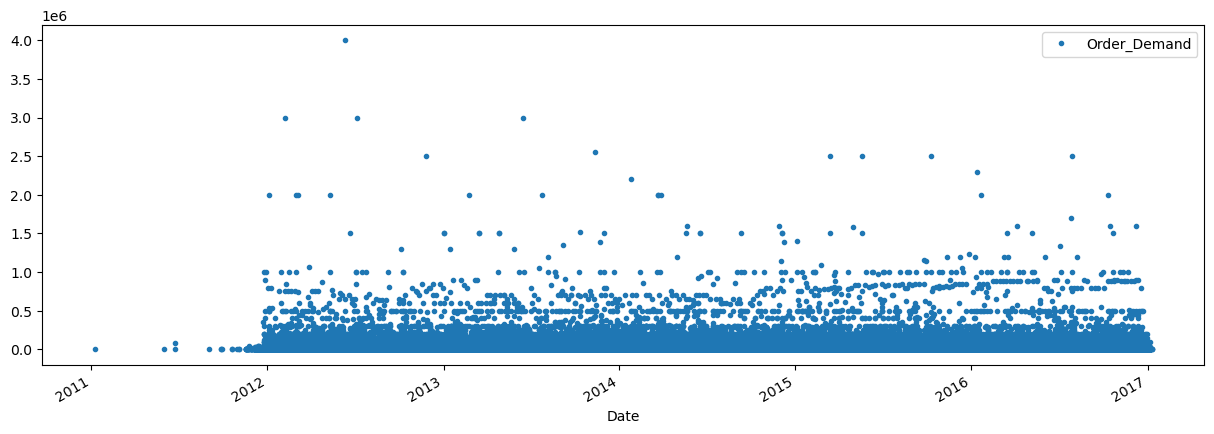

In [63]:
##Plotting
og_data.plot(style= '.', figsize=(15,5))

<Axes: xlabel='Date'>

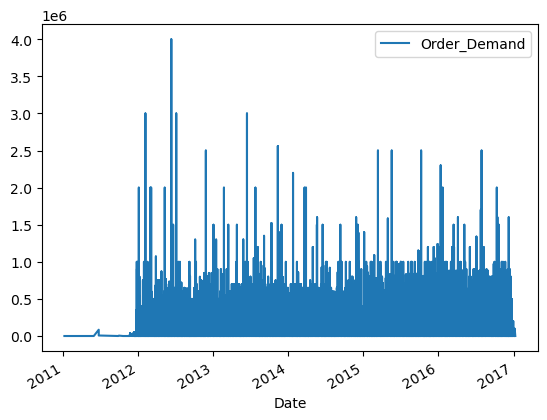

In [64]:
og_data.plot()

## Use standard deviation to identify outliers 3s includes 99,7%

In [65]:
og_data.describe().apply(lambda s: s.apply('{0:.1f}'.format))

,Order_Demand
count,1037336.0
mean,4949.4
std,29073.4
min,0.0
25%,20.0
50%,300.0
75%,2000.0
max,4000000.0


## Create upper limit base on standar deviation

In [66]:
upper_limit= og_data.Order_Demand.mean() + 3* og_data.Order_Demand.std()


In [67]:
og_data[(og_data.Order_Demand >= upper_limit)]


,Product_Code,Warehouse,Product_Category,Order_Demand
Date,,,,
2012-01-18,Product_1159,Whse_J,Category_006,100000
2012-10-01,Product_1159,Whse_J,Category_006,100000
2012-10-18,Product_1159,Whse_J,Category_006,100000
2012-03-08,Product_1157,Whse_J,Category_006,150000
2012-03-08,Product_1157,Whse_J,Category_006,150000
...,...,...,...,...
2016-12-02,Product_1149,Whse_J,Category_006,100000
2016-12-09,Product_1149,Whse_J,Category_006,100000
2016-03-09,Product_1149,Whse_J,Category_006,100000


## Group dataset by order and date

In [68]:
group_df= og_data.groupby('Date').agg(sum)

C:\Users\John\AppData\Local\Temp\ipykernel_20784\3612321277.py:1: FutureWarning: The operation <built-in function sum> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  group_df= og_data.groupby('Date').agg(sum)


In [69]:
#Set frequency as date
group_df = group_df.asfreq('d')
group_df.index


DatetimeIndex(['2011-01-08', '2011-01-09', '2011-01-10', '2011-01-11',
               '2011-01-12', '2011-01-13', '2011-01-14', '2011-01-15',
               '2011-01-16', '2011-01-17',
               ...
               '2016-12-31', '2017-01-01', '2017-01-02', '2017-01-03',
               '2017-01-04', '2017-01-05', '2017-01-06', '2017-01-07',
               '2017-01-08', '2017-01-09'],
              dtype='datetime64[ns]', name='Date', length=2194, freq='D')

## How to handles missing dates?

# 1 way Exponential (Weighted) Moving Average:

In [70]:
group_df['Order_Demand'] = group_df['Order_Demand'].ewm(halflife=4).mean()

In [71]:
group_df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2194 entries, 2011-01-08 to 2017-01-09
Freq: D
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Order_Demand  2194 non-null   float64
dtypes: float64(1)
memory usage: 34.3 KB


## Check if time-series is stationary

In [72]:
test_result= adfuller(group_df['Order_Demand'])

<Axes: xlabel='Date'>

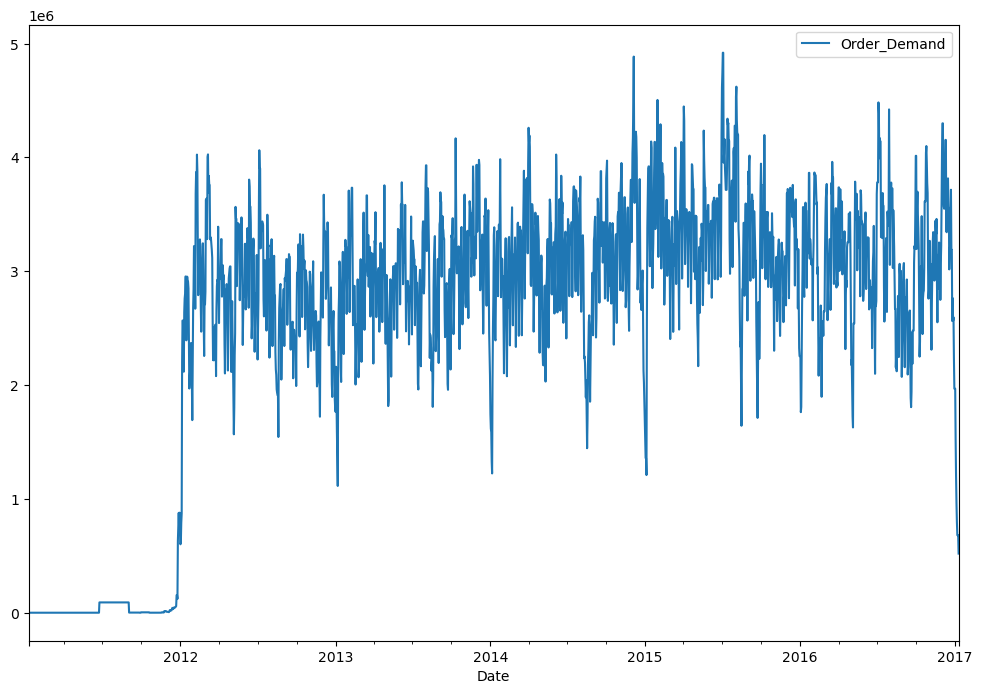

In [73]:
group_df.plot(figsize=(12, 8))

In [74]:
dfoutput = pd.Series(
test_result[0:4],
index=[
"Test Statistic",
"p-value",
"#Lags Used",
"Number of Observations Used",
],)

In [75]:
for key, value in test_result[4].items():
    dfoutput["Critical Value (%s)" % key] = value
print(dfoutput)

# Interpret the results
if dfoutput['p-value'] < 0.05:
    print("The time series is likely stationary (reject the null hypothesis)")
else:
    print("The time series is likely non-stationary (fail to reject the null hypothesis)")

Test Statistic                   -2.437840
p-value                           0.131340
#Lags Used                       26.000000
Number of Observations Used    2167.000000
Critical Value (1%)              -3.433371
Critical Value (5%)              -2.862875
Critical Value (10%)             -2.567481
dtype: float64
The time series is likely non-stationary (fail to reject the null hypothesis)


## If the model is non-stationary I can implement differencing to make it stationary


## Auto regressive Model


In [80]:
model= ARIMA(group_df['Order_Demand'], order=(1,1,1))
model_fit= model.fit()

In [81]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Order_Demand   No. Observations:                 2194
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -30880.017
Date:                Tue, 06 Jun 2023   AIC                          61766.034
Time:                        15:54:02   BIC                          61783.113
Sample:                    01-08-2011   HQIC                         61772.276
                         - 01-09-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6408      0.055    -11.662      0.000      -0.749      -0.533
ma.L1          0.7857      0.044     17.687      0.000       0.699       0.873
sigma2      1.029e+11   1.86e-13   5.53e+23      0.000    1.03e+11    1.03e+11
===================================================================================
Ljung-Box (L1) (Q):                   4.61   Jarque-Bera (JB):                99.78
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               2.27   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.98e+38. Standard errors may be unstable.
"""

<Axes: xlabel='Date'>

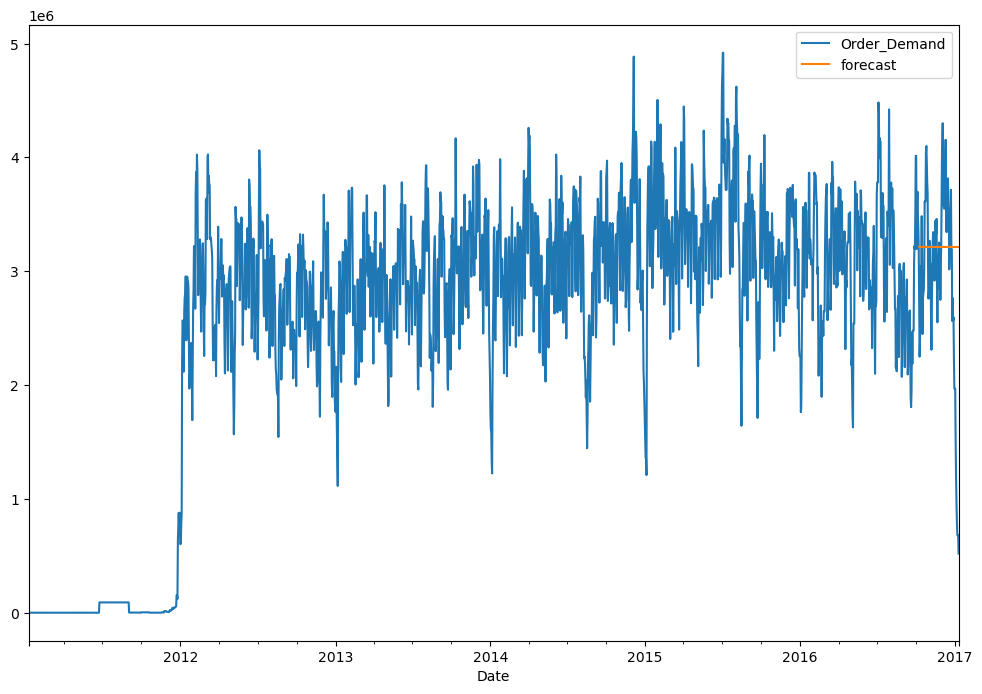

In [82]:
group_df['forecast']= model_fit.predict(start=2100, end= 2195, dynamic=True)
group_df[['Order_Demand', 'forecast']].plot(figsize=(12,8))

In [79]:
group_df.tail(5)

,Order_Demand,forecast
Date,,
2017-01-05,796975.296492,2.552414e+06
2017-01-06,681002.337070,2.552414e+06
2017-01-07,681002.337070,2.552414e+06
2017-01-08,681002.337070,2.552414e+06
2017-01-09,519399.821924,2.552414e+06
